# Basics of Mobile Robotics Project

## Color calibration
In order to detect the colors one should first calibrate 
the filters using the color_calibration.py script. 
Trackbars are used to easily set the HSV parameters 
and isolate the desired color. The parameters are then saved in a txt file.


In [1]:
# !python color_calibration.py


## Main

**imports**

In [2]:
%matplotlib inline
import os
import glob
import numpy as np
import time
import json
import matplotlib.image as mpimg

from particle_filter import *
import utils as ut
import Thymio_custom
import global_controller
import Pathplanning
import control
from local_avoidance import local_avoidance

**Loading files**

In [3]:
map_file = "data\\mapA0.png"
save_dir = "output\\particles_"

# importing sensor calibration data
config_filename = 'data\\config_TP465.json'
with open(config_filename) as infile:
    config = json.load(infile)
    
# importing the ground map, and converting it to a map in sensor values for each sensor
ground_map = np.flipud(mpimg.imread(map_file).astype(float))[:, :, 0]
vUnitToSensor = np.vectorize(ut.unit_to_sensor, excluded=[1])
ground_map_left = vUnitToSensor(np.transpose(ground_map), config['left'])
ground_map_right = vUnitToSensor(np.transpose(ground_map), config['right'])


### vision
The vision functions can detect the position of the obstacles, goal and thymio 
as well as its orientation. It also detects the map boundaries and projects it. 
the draw functions can be used for debugging


In [12]:
x, y, theta, goal, obsList = Pathplanning.take_picture_to_init(margeObs=8.5, cam_capture=0)

space pressed


BLABLA PATH FINDING

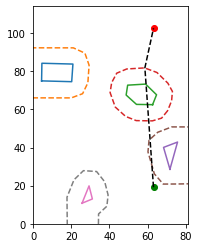

In [13]:
path=None
path = Pathplanning.find_path([x, y], goal, obsList, plotFlag=True)

path = [np.array(tup) for tup in path]  # converting tuples in np array
glob_ctrl = global_controller.GlobalController(path, tubeTol=4, outOfTubeAvancementTarget=3, noTurningDistance=3 )

### Communication with the Thymio
We modified the provided interface to best fit our needs. Indeed we needed a high reactivity to be able to avoid 
the local obstacles and a precise incrementation of the odometry. We therefore added some functions of our own in 
the refreshing thread. 

Connection to the thymio:

In [6]:
thymio = Thymio_custom.Thymio.serial(port="COM14", refreshing_rate=0.1, global_controller=glob_ctrl)

### Particle filter
We decided to implement a Monte Carlo localization that we adapted from the paper *Wang S., Colas F., Liu M., Mondada F., Magnenat S. (2018) Localization of Inexpensive Robots with Low-Bandwidth
Sensors.* <br>
A lot of effort was spent to decrease the computation time of this algorithm. Because we weren't satisfied with 
the performance given by the Cython library originally used, we decided to optimize the code with Numba, achieving a 
10 times lower execution time of around 400ms for 150000 particles, wich is great enough for this project. <br>
The three main steps are 
1. Propagating the particles with the measured odometry
2. Calculating the likelihood of each particle with respect to the ground sensor measurements, 
and resampling them according to their probability
3. Estimating the real state using a RANSAC algorithm <br><br>

Initialisation of the localiser:

In [7]:
loc = MonteCarlo(ground_map_left, ground_map_right, particles_count=150000, sigma_obs=150., prop_uniform=0,
                 alpha_xy=0.1, alpha_theta=0.1,  state_init=[x, y, theta])

Remove previous output plots, plot the inital state and reset thymio


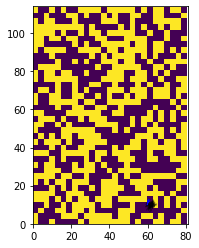

In [8]:
for fl in glob.glob(save_dir+"*"):
    os.remove(fl)

loc.plot_state( map_back=ground_map, num_particles=50)

Thymio_custom.wait_init(thymio)
Thymio_custom.reset_thymio(thymio)

### main loop

In [10]:
i = 1
d_reck = np.array([x, y, theta])  # dead_reckoning --> debug but doesn't harm
thymio.start_t = time.time()
try:
    while glob_ctrl.state is not "reachedGoal":

        print("----------------------", i, "t{:0.2f}".format(time.time()-thymio.start_t))
        sensor_left, sensor_right, dx, dy, dth = thymio.read_odometry()

        # localization
        start_t_loc = time.time()
        loc.apply_command(dx, dy, dth)
        loc.apply_obs_and_resample(sensor_left, sensor_right)
        est_pos, confidence = loc.estimate_state()
        duration = time.time() - start_t_loc

        print("Estimated state: {:0.2f} {:0.2f} {:0.2f}".format(est_pos[0], est_pos[1], est_pos[2]))
        if confidence < 0.7:
            print("WARNING LOW CONFIDENCE:", confidence)
        else:
            print("Confidence:", confidence)

        # odometry alone --> debug purposes, but doesn't harm anyone if kept
        d_reck[0:2] += (ut.rot_mat2(d_reck[2]) @ np.asarray([dx, dy]).T).T
        d_reck[2] += dth

        # plotting
        plot_time = time.time()  # yes it takes time !
        loc.plot_state(map_back=ground_map, num_particles=50, odom=d_reck,
                       sens=[sensor_left, sensor_right], path=path)  # base_filename=save_dir+str(i),
        print("Duration algo, plot : {} , {} ms".format(round(1000*duration), round(1000 * (time.time() - plot_time))))

        glob_ctrl.followPath(est_pos[0:2], est_pos[2], thymio, thymio.nav_flag)

        if thymio.nav_flag == "local":
            thymio.set_var_array("leds.top", [255, 255, 0])  # yellow
            local_avoidance(thymio)
        elif glob_ctrl.state == "start":  # everything is going well
            thymio.set_var_array("leds.top", [0, 255, 0])  # green
        elif thymio.nav_flag == "global":  # coming back to the planned path
            thymio.set_var_array("leds.top", [0, 0, 255])  # blue

        i += 1
        time.sleep(0.2)  # slow down the loop

    thymio.set_var_array("leds.top", [255, 0, 127])  # pink when loop is exited normally --> goal reached
except:
    thymio.set_var_array("leds.top", [255, 0, 0])  # red
    pass

control.stop_thymio(thymio)

---------------------- 1 t0.00
Estimated state: 62.18 14.27 2.06
Confidence: 0.768
Duration algo, plot : 587 , 64 ms
NavType: global // self.state: wait // pos : [62.17523408 14.26632502]
has finished waiting
---------------------- 2 t0.86
Estimated state: 61.79 14.01 2.06
Confidence: 0.758
Duration algo, plot : 682 , 91 ms
NavType: global // self.state: turnInTube // pos : [61.78892851 14.01109411]
turning in tube -0.42461198266114053
---------------------- 3 t1.83
Estimated state: 61.94 14.42 2.07
Confidence: 0.766
Duration algo, plot : 718 , 52 ms
NavType: global // self.state: wait // pos : [61.94313733 14.41852971]
has finished waiting
---------------------- 4 t2.80
Estimated state: 61.55 14.42 1.71
Confidence: 0.7026666666666667
Duration algo, plot : 581 , 72 ms
NavType: global // self.state: straightInTube // pos : [61.55070511 14.4166956 ]
---------------------- 5 t3.66


In [14]:
control.stop_thymio(thymio)